# Implementing Gradient Descent with TensorFlow

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
HR = pd.read_csv(r"D:\Data_sets\HR.csv") # Same data as ordinary least squares notebook

In [3]:
HR[['average_montly_hours','last_evaluation']].values.std(axis=0)

array([ 49.94143446,   0.1711634 ])

In [4]:
X = HR[['average_montly_hours','last_evaluation']].values
y = HR['satisfaction_level'].values

X = (X - X.mean(axis=0)) / X.std(axis=0) #Normalise features
y = (y - y.mean()) / y.std()

m = X.shape[0]
n = X.shape[1]

X = np.c_[np.ones((m,1)), X] #Add bias 

X = tf.constant(X, dtype=tf.float32, name="X")
y = tf.constant(y.reshape(-1, 1), dtype=tf.float32, name="y") #y is an array, needs to be a column vector

In [5]:
n_epochs = 1000
learning_rate = 0.01

In [6]:
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, -1.0, name="theta")) #Randomly initialise weights (Break symmetry)
y_pred = tf.matmul(X, theta, name="predictions") 
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse") # mean squared error for regression
#gradients = 2/m * tf.matmul(tf.transpose(X), error) # calculating gradients manually
gradients = tf.gradients(mse, [theta])[0] # This is why TF is awesome - autodiff feature
training_op = tf.assign(theta, theta - learning_rate * gradients) # theta = theta - alpha*gradients 

In [7]:
init = tf.global_variables_initializer()

In [8]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE=", mse.eval())
    
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE= 4.84943
Epoch 100 MSE= 1.01635
Epoch 200 MSE= 0.985882
Epoch 300 MSE= 0.985469
Epoch 400 MSE= 0.98546
Epoch 500 MSE= 0.985459
Epoch 600 MSE= 0.985459
Epoch 700 MSE= 0.985459
Epoch 800 MSE= 0.985459
Epoch 900 MSE= 0.985459


In [9]:
best_theta # Slightly different from before, because values are normalised

array([[ -3.39530821e-08],
       [ -6.29996061e-02],
       [  1.26424447e-01]], dtype=float32)

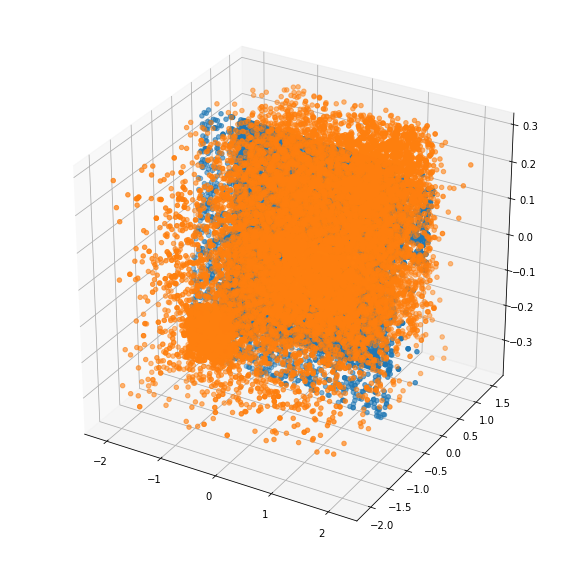

In [10]:
with tf.Session() as sess:
    predictions = tf.matmul(X, best_theta).eval()

X = HR['average_montly_hours'].values
Z = HR['last_evaluation'].values
y = HR['satisfaction_level'].values


X = (X - X.mean()) / X.std()
Z = (Z - Z.mean()) / X.std()#Normalise features
y = (y - y.mean()) / y.std()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, predictions, Z,  depthshade=True)
ax.scatter(X, y, Z, depthshade=True);

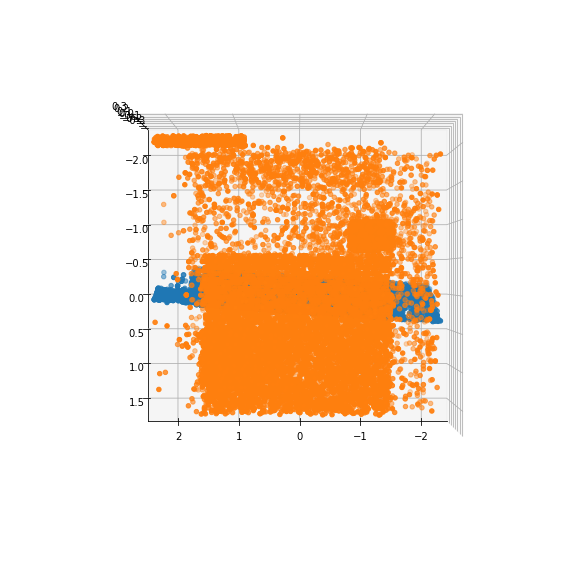

In [11]:
ax.view_init(90, 90)
fig

Exact same result as using the normal equation in the previous notebook, success!

### Mini-batch gradient descent

In [12]:
tf.reset_default_graph()

In [13]:
X = HR[['average_montly_hours','last_evaluation']].values
y = HR['satisfaction_level'].values

Xnorm = (X - X.mean(axis=0)) / X.std(axis=0) #Normalise features
ynorm = (y - y.mean()) / y.std()

m = X.shape[0]
n = X.shape[1]

Xnorm = np.c_[np.ones((m,1)), Xnorm] #Add bias 

In [14]:
def fetch_batch(batch_index, batch_size):
    
    i1 = batch_index * batch_size
    i2 = i1 + batch_size
    
    X_batch = Xnorm[i1:i2,:]
    y_batch = ynorm.reshape(-1,1)[i1:i2,:]
    
    return X_batch, y_batch

In [15]:
X = tf.placeholder(tf.float32, shape=(None, n+1), name="X") #Placeholders for batches
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, -1.0, name="theta"))
y_pred = tf.matmul(X, theta, name="predictions") 
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse") 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)                                                 

In [16]:
init = tf.global_variables_initializer()

In [17]:
with tf.Session() as sess:
    sess.run(init)
    
    
    for epoch in range(n_epochs):
        
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(batch_index, batch_size)
            sess.run(training_op,feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [18]:
best_theta

array([[-0.03890643],
       [-0.06465784],
       [ 0.13078974]], dtype=float32)

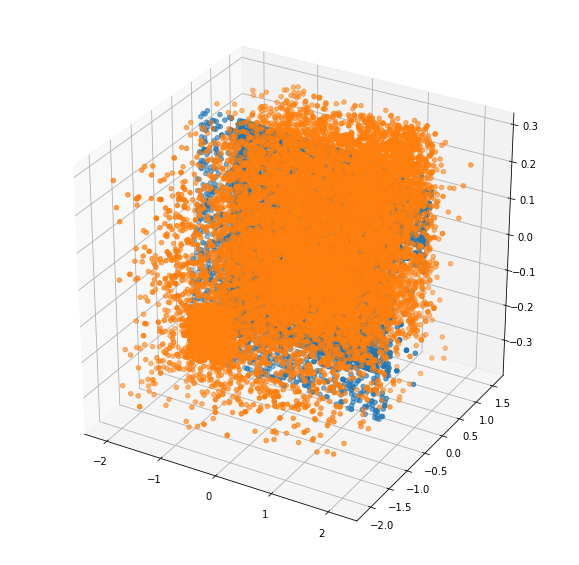

In [19]:
X = HR[['average_montly_hours','last_evaluation']].values
y = HR['satisfaction_level'].values

X = (X - X.mean(axis=0)) / X.std(axis=0) #Normalise features
y = (y - y.mean()) / y.std()

X = np.c_[np.ones((m,1)), X] #Add bias 

X = tf.constant(X, dtype=tf.float32, name="X")
y = tf.constant(y.reshape(-1, 1), dtype=tf.float32, name="y") #y is an array, needs to be a column vector

with tf.Session() as sess:
    predictions = tf.matmul(X, best_theta).eval()

X = HR['average_montly_hours'].values
Z = HR['last_evaluation'].values
y = HR['satisfaction_level'].values

X = (X - X.mean()) / X.std()
Z = (Z - Z.mean()) / X.std()#Normalise features
y = (y - y.mean()) / y.std()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, predictions, Z,  depthshade=True)
ax.scatter(X, y, Z, depthshade=True);

Same result - it works, but slower. 